# **Project**
## **Prediction of Ames house price and the impact of proximity to amenities**
### **Busniess Question:** 
### Does the proximity to amenities (Parklands or Iowa State University) have an impact on the predicted sale price of Ames properties in 2006~2010?
### **Stakeholders -**
### House buyers & house owners


### Table of Contents

* [Section 1. Import dataset](#section1)
    * [1.1 Read csv files](#section_1_1)
    * [1.2 Numerical features](#section_1_2)
    * [1.3 Target variable](#section_1_3)
* [Section 2. Proximity to amenities](#section2a)
    * [2.1 Folium map](#section_2_a)
    * [2.2 Mapping of house price and proximity to amenities](#section_2_b)
* [Section 3. House price prediction](#section3a)
    * [3.1 Categorical features - ordinal encoding](#section_3_a)
    * [3.2 Forward feature selection](#section_3_b)
    * [3.3 Cross validation](#section_3_c)
* [Section 4. House price prediction](#section4)
    * [4.1 Categorical features - one-hot encoding](#section_4_1)
    * [4.2 Linear regression models](#section_4_2)
    * [4.3 Cross validation](#section_4_3)
* [Section 5. Summary](#section5)


## Section 1.  Import dataset <a class="anchor" id="section1"></a> 


 - Import libraries

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import folium

from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error


### Section 1.1 Read csv files <a class="anchor" id="section_1_1"></a>


- **Load the dataset**

In [8]:
house = pd.read_csv('train.csv')
print(house.columns)
print('_'*100)
#house.describe().T
#house.info()


Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

- **Remove Outliers**
   * Only two properties in 'Blueste' were sold, which is not representative of that neighborhood
   * Only resedential properties are considered, and thus commercial properties (10 rows) are removed

In [9]:
house.drop(house.index[house['Neighborhood']=='Blueste'], inplace=True)
print(house.shape)
house.drop(house.index[house['MSZoning']=='C (all)'], inplace=True)
print(house.shape)
#house['MSZoning'].value_counts()

(1458, 81)
(1448, 81)


In [10]:
house.filter(like='Bath', axis=1).describe().T


,count,mean,std,min,25%,50%,75%,max
BsmtFullBath,1448.0,0.427486,0.519413,0.0,0.0,0.0,1.0,3.0
BsmtHalfBath,1448.0,0.057320,0.238404,0.0,0.0,0.0,0.0,2.0
FullBath,1448.0,1.569061,0.549608,0.0,1.0,2.0,2.0,3.0
HalfBath,1448.0,0.383978,0.503278,0.0,0.0,0.0,1.0,2.0


### Section 1.2 Numerical features <a class="anchor" id="section_1_2"></a>


- **Adjust numerical features**
   * Calculate SalePrice_per_sqft = SalePrice / LotArea
   * Calculate AgeBuilt = YrSold - YearBuilt
   * Calculate AgeRemod = YrSold = YearRemodAdd
   * Calculate BathRoom = FullBath + HalfBath*0.5
   * Calculate BsmtBath = BsmtFullBath + BsmtHalfBath*0.5

In [11]:
house['SalePrice_per_sqft'] = house['SalePrice'] / house['LotArea']
house['AgeBuilt'] = house['YrSold'] - house['YearBuilt']
house['AgeRemod'] = house['YrSold'] - house['YearRemodAdd']

house['Bathroom'] = house['FullBath'] + house['HalfBath'] / 2
house['BsmtBath'] = house['BsmtFullBath'] + house['BsmtHalfBath'] / 2

house.drop(columns=['Id','FullBath','HalfBath','BsmtFullBath','BsmtHalfBath', 'YearBuilt', 'YearRemodAdd'], inplace=True)
house.shape

(1448, 79)

- **Adjust caltegorical features - Condition1 & Condition2**
   * Change ['PosN','PosA'] to'Pos'
   * Change ['RRNn','RRAn','Feedr','Artery','RRNe','RRAe'] to'Neg'
   * Combine "Condition1" and "Condition2" into "Condition"

In [12]:
house['Condition1'].replace(['PosN','PosA'],'Pos', inplace=True)
house['Condition1'].replace(['RRNn','RRAn','Feedr','Artery','RRNe','RRAe'],'Neg', inplace=True)
house['Condition2'].replace(['PosN','PosA'],'Pos', inplace=True)
house['Condition2'].replace(['RRNn','RRAn','Feedr','Artery','RRNe','RRAe'],'Neg', inplace=True)
house['Condition'] = house['Condition1'] + house['Condition2']

print(house['Condition'].value_counts())
house.drop(columns=['Condition1','Condition2'], inplace=True)
house.shape


NormNorm    1250
NegNorm      159
PosNorm       25
NegNeg        11
PosPos         2
NegPos         1
Name: Condition, dtype: int64


(1448, 78)

### Section 1.3 Target variable <a class="anchor" id="section_1_3"></a>


- **Target variable**
   * SalePrice has long tail (right skew) toward high price
   * Taking logarithmic function to SalePrice, it becomes more like normal distribution
   * SalePrice_per_sqft has even longer tail that the distribution is asymetric after taking logarithmic function

- Consequently, **log10(SalePrice)** is chosen as the target variable

Text(0.5, 0, 'log10(SalePrice_per_sqft)')

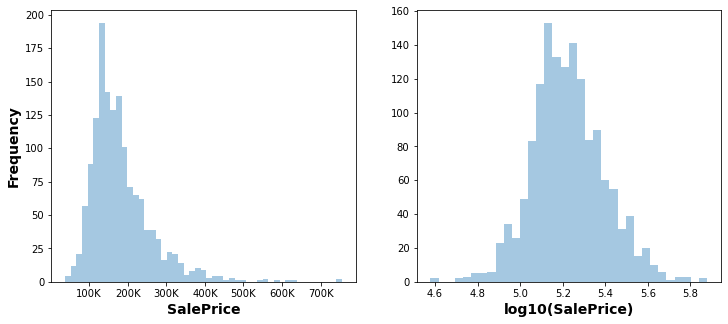

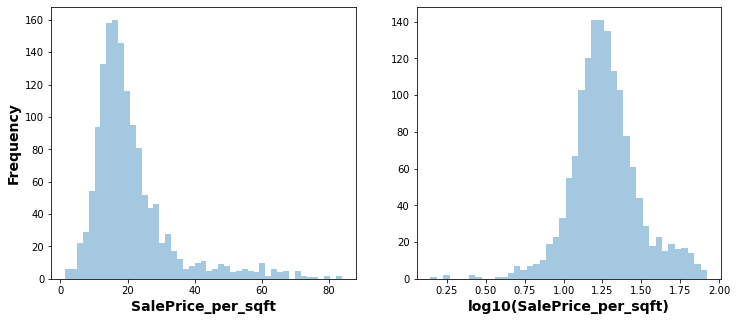

In [13]:
fig, ax = plt.subplots(1,2,figsize=[12,5])
_ = sns.distplot(house['SalePrice'], kde=False, norm_hist=False, ax=ax[0])
ax[0].set_ylabel('Frequency',fontsize=14, fontweight='bold')
_ = sns.distplot(np.log10(house['SalePrice']), kde=False, norm_hist=False, ax=ax[1])
xlabels = ['{:,.0f}'.format(x) + 'K' for x in ax[0].get_xticks()/1000]
ax[0].set_xticklabels(xlabels)
ax[0].set_xlabel('SalePrice',fontsize=14, fontweight='bold')
ax[1].set_xlabel('log10(SalePrice)',fontsize=14, fontweight='bold')

fig, ax = plt.subplots(1,2,figsize=[12,5])
_ = sns.distplot(house['SalePrice_per_sqft'], kde=False, norm_hist=False, ax=ax[0])
ax[0].set_ylabel('Frequency',fontsize=14, fontweight='bold')
_ = sns.distplot(np.log10(house['SalePrice_per_sqft']), kde=False, norm_hist=False, ax=ax[1])
#_ = sns.distplot(np.sqrt(house['SalePrice']), kde=False, norm_hist=False, ax=ax[1])
ax[0].set_xlabel('SalePrice_per_sqft',fontsize=14, fontweight='bold')
ax[1].set_xlabel('log10(SalePrice_per_sqft)',fontsize=14, fontweight='bold')


## Section 2.  Proximity to amenities <a class="anchor" id="section2a"></a> 


- **EDA**
   * get the following important statistics for each neighborhood:
    * median SalePrice
    * median SalePrice per LotArea
    * average LogArea
    * average Cars
    * average Bedrooms
    * average Overall Quality
    * Full name of neighborhood
   * impoprt latitude and longitude of each neighborhood

In [14]:
df_Neighborhood = house.groupby('Neighborhood') \
                       .agg({'SalePrice':'median',
                             'SalePrice_per_sqft':'median',
                             'LotArea':'median',
                             'GarageCars':'mean',
                             'BedroomAbvGr':'mean',
                             'OverallQual':'mean'})

df_gps = pd.read_csv('Ames Neighborhoods.csv')
df_Neighborhood = df_Neighborhood.join(df_gps.set_index('Neighborhood'))
df_Neighborhood.reset_index(inplace=True)
df_Neighborhood

,Neighborhood,SalePrice,SalePrice_per_sqft,LotArea,GarageCars,BedroomAbvGr,OverallQual,Name,X,Y
0,Blmngtn,191000,58.183594,3182.0,2.352941,1.823529,7.176471,Bloomington Heights,42.0628,-93.6419
1,BrDale,106000,56.482410,1680.0,1.125000,2.500000,5.687500,Briardale,42.0530,-93.6290
2,BrkSide,124300,16.789668,6240.0,1.172414,2.603448,5.051724,Brookside,42.0315,-93.6250
3,ClearCr,200250,11.069819,17575.0,1.750000,2.892857,5.892857,Clear Creek,42.0290,-93.6695
4,CollgCr,197200,21.136916,9356.0,2.006667,2.820000,6.640000,College Creek,42.0210,-93.6880
5,Crawfor,200624,18.992863,11500.0,1.627451,2.980392,6.274510,Crawford,42.0150,-93.6440
6,Edwards,121750,13.091314,9091.0,1.180000,2.880000,5.080000,Edwards,42.0220,-93.6660
7,Gilbert,181000,18.945212,9967.0,2.063291,3.101266,6.556962,Gilbert,42.0600,-93.6386
8,IDOTRR,112500,14.178357,7324.5,0.928571,2.642857,5.107143,Iowa DOT and Rail Road,42.0230,-93.6270
9,MeadowV,88000,43.151970,1974.0,0.882353,2.411765,4.470588,Meadow Village,41.9918,-93.6020


### Section 2.1 Folium map <a class="anchor" id="section_2_a"></a>


- **EDA**
   * impoprt latitude and longitude of amenities (parklands, uni and airport)
   * column 'attribute' indicates the 'positive' or 'negative' impact on the property price

In [15]:
df_park = pd.read_csv('Ames Parklands and Uni.csv')
df_park

,Name,X,Y,attribute
0,Ada Hayden Heritage Park,42.0665,-93.6305,Pos
1,Moore Memorial Park,42.0436,-93.6520,Pos
2,North River Valley Park,42.0365,-93.6000,Pos
3,Emma McCarthy Lee Park,42.0313,-93.6630,Pos
4,Iowa State University,42.0280,-93.6440,Neg
5,Ames Airport,41.9926,-93.6210,Neg
6,Stuart Smith Park,42.0230,-93.6320,Pos
7,Brookside Park,42.0310,-93.6320,Pos


- **Generate folium map of Ames**
   * locate each neighborhood with circle size representing median SalePrice
    * important statistics are shown in popup or tooltip
   * locate all amenities
    * Parklands are shown in green (positive amenity)
    * Uni and airport are shown in blue (negative amenity)
    * Amenity name is shown in popup or tooltip

In [22]:
def generateBaseMap(default_location=[42.0347, -93.62], default_zoom_start=12.2):
    '''
    Create a base map
    '''
    base_map = folium.Map(
        location = default_location
        , control_scale = True
        , zoom_start = default_zoom_start
    )
    
    return base_map

In [23]:
base_map = generateBaseMap(default_location=[42.033, -93.62])

for k in range(len(df_Neighborhood)) :
    n = df_Neighborhood.iloc[k]['Neighborhood']
    s = '\n${:2.0f}'.format(df_Neighborhood.iloc[k]['SalePrice'])
    b = '\n{:2.1f} Bed'.format(df_Neighborhood.iloc[k]['BedroomAbvGr'])
    g = '\n{:2.1f} Car'.format(df_Neighborhood.iloc[k]['GarageCars'])
    q = '\n{:2.1f} Qual'.format(df_Neighborhood.iloc[k]['OverallQual'])
    q = '\n{:2.1f} Area'.format(df_Neighborhood.iloc[k]['LotArea'])
    tooltip_str = n + ': '+ s + ', ' + b + ', ' + g + ', ' + q
    popup_str = n + s + b + g + q
    folium.Circle(
        location=[df_Neighborhood.iloc[k]['X'], df_Neighborhood.iloc[k]['Y']], 
        radius=df_Neighborhood.iloc[k]['SalePrice']/1000, 
#        radius=df_Neighborhood.iloc[k]['SalePrice_per_sqft']*5, 
#        radius=df_Neighborhood.iloc[k]['OverallQual']*25, 
#        radius=df_Neighborhood.iloc[k]['GarageCars']*100, 
        popup=popup_str,
        tooltip=tooltip_str
    ).add_to(base_map)
    
    if False :
        folium.Circle(
            location=[df_Neighborhood.iloc[k]['X'], df_Neighborhood.iloc[k]['Y']], 
#            radius=df_Neighborhood.iloc[k]['GarageCars']*75, 
            radius=df_Neighborhood.iloc[k]['OverallQual']*25, 
            color='red'
        ).add_to(base_map)

if True:
    for k in range(len(df_park)) :
        if df_park.iloc[k]['attribute']=='Pos' : # Parklands
            marker_color = 'green'
        else : # University & Airport
            marker_color = 'blue'
        folium.Marker(
            location = [df_park.iloc[k]['X'], df_park.iloc[k]['Y']],
            popup = df_park.iloc[k]['Name'],
            tooltip = df_park.iloc[k]['Name'],
            icon = folium.Icon(color=marker_color, icon='info-sign')
        ).add_to(base_map)

display(base_map)


### Section 2.2 Mapping of house price and proximity to amenities <a class="anchor" id="section_2_2"></a>


- **Proximity to amenities**
   * calculate the shortest distance between the neighborhood and 'positive' amenities
   * calculate the shortest distance between the neighborhood and 'negative' amenities

In [24]:
from math import cos, asin, sqrt

def calculate_distance(lat1, lon1, lat2, lon2):
    """ calculate the distance in km between two locations (lat1, lon1) and (lat2, lon2) """
    # p = pi/180
    p = 0.017453292519943295
    a = 0.5 - cos((lat2 - lat1) * p)/2 + cos(lat1 * p) * cos(lat2 * p) * (1 - cos((lon2 - lon1) * p)) / 2
    
    return 12742 * asin(sqrt(a))


In [25]:
def calculate_distance_to_amenity(df_Neighborhood, df_amenity):
    """ find the shortest distance of each Neibhborhood in df_Neighborhood to any amenity in df_amenity """
    
    distance_to_amenity =[]

    for k in range(len(df_Neighborhood)) :
        n = df_Neighborhood.iloc[k]['Neighborhood']
        distance = 1e8
        lat1 = df_Neighborhood.iloc[k]['X']
        lon1 = df_Neighborhood.iloc[k]['Y']
        for idx in range(len(df_amenity)) :
            lat2 = df_amenity.iloc[idx]['X']
            lon2 = df_amenity.iloc[idx]['Y']
            distance = np.min([distance, calculate_distance(lat1, lon1, lat2, lon2)])

        distance_to_amenity.append(distance)
    
    return distance_to_amenity


In [26]:
df_amenity = df_park.loc[df_park['attribute']=='Pos']

df_Neighborhood['distance_to_pos'] = calculate_distance_to_amenity(df_Neighborhood, df_amenity)
#df_Neighborhood

df_amenity = df_park.loc[df_park['attribute']=='Neg']

df_Neighborhood['distance_to_neg'] = calculate_distance_to_amenity(df_Neighborhood, df_amenity)
#df_Neighborhood

In [27]:
def calculate_aggregated_distance_to_amenity(df_Neighborhood, df_park):
    """ For each Nieghborhood, find the total distance to parklands minus the total distance to Uni and airport """
    
    aggregated_distance =[]

    for k in range(len(df_Neighborhood)) :
        n = df_Neighborhood.iloc[k]['Neighborhood']
        distance = 0
        lat1 = df_Neighborhood.iloc[k]['X']
        lon1 = df_Neighborhood.iloc[k]['Y']
        for idx in range(len(df_park)) :
            lat2 = df_park.iloc[idx]['X']
            lon2 = df_park.iloc[idx]['Y']
            if df_park.iloc[idx]['attribute']=='Pos':
                distance = distance + calculate_distance(lat1, lon1, lat2, lon2)
            else:
                distance = distance - calculate_distance(lat1, lon1, lat2, lon2)
 
        aggregated_distance.append(distance)
    
    return aggregated_distance


In [28]:
df_Neighborhood['agg_distance'] = calculate_distance_to_amenity(df_Neighborhood, df_park)


In [29]:
df_Neighborhood

,Neighborhood,SalePrice,SalePrice_per_sqft,LotArea,GarageCars,BedroomAbvGr,OverallQual,Name,X,Y,distance_to_pos,distance_to_neg,agg_distance
0,Blmngtn,191000,58.183594,3182.0,2.352941,1.823529,7.176471,Bloomington Heights,42.0628,-93.6419,1.027073,3.873467,1.027073
1,BrDale,106000,56.482410,1680.0,1.125000,2.500000,5.687500,Briardale,42.0530,-93.6290,1.506231,3.043373,1.506231
2,BrkSide,124300,16.789668,6240.0,1.172414,2.603448,5.051724,Brookside,42.0315,-93.6250,0.580820,1.616848,0.580820
3,ClearCr,200250,11.069819,17575.0,1.750000,2.892857,5.892857,Clear Creek,42.0290,-93.6695,0.594670,2.109154,0.594670
4,CollgCr,197200,21.136916,9356.0,2.006667,2.820000,6.640000,College Creek,42.0210,-93.6880,2.361345,3.716906,2.361345
5,Crawfor,200624,18.992863,11500.0,1.627451,2.980392,6.274510,Crawford,42.0150,-93.6440,1.331921,1.445534,1.331921
6,Edwards,121750,13.091314,9091.0,1.180000,2.880000,5.080000,Edwards,42.0220,-93.6660,1.063388,1.935833,1.063388
7,Gilbert,181000,18.945212,9967.0,2.063291,3.101266,6.556962,Gilbert,42.0600,-93.6386,0.984637,3.586070,0.984637
8,IDOTRR,112500,14.178357,7324.5,0.928571,2.642857,5.107143,Iowa DOT and Rail Road,42.0230,-93.6270,0.413020,1.510273,0.413020
9,MeadowV,88000,43.151970,1974.0,0.882353,2.411765,4.470588,Meadow Village,41.9918,-93.6020,4.263803,1.572755,1.572755


- **Scatter plot of house price as a function of proximity to amenities**
   * SalePrice per LotArea shows:
    * a positive trend with 'distance to Parklands'
    * a negative trend with 'distance to Uni or airport'
   * SalePrice does not show a clear correlation due to different average LotArea of each neighborhood


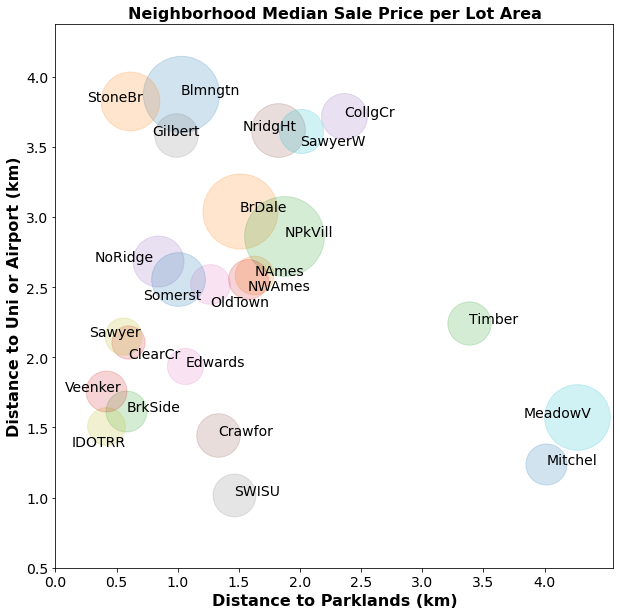

In [30]:
plt.rc('font', size = 14)
fig, ax = plt.subplots(figsize=[10,10])

for key, row in df_Neighborhood.iterrows():
#    ax.scatter(row['distance_to_pos'], row['distance_to_neg'], s=row['SalePrice']/100, alpha=.2)
    ax.scatter(row['distance_to_pos'], row['distance_to_neg'], s=row['SalePrice_per_sqft']*100, alpha=.2)
    
    dx=0
    dy=0
    if row['Neighborhood'] in ['StoneBr','Somerst','NridgHt','Gilbert','MeadowV'] :
        dx = -0.01
    elif row['Neighborhood'] in ['NoRidge','IDOTRR','Veenker','Sawyer'] :
        dx = -0.02
    if row['Neighborhood'] in ['IDOTRR','OldTown','ClearCr'] :
        dy = -0.01
    elif row['Neighborhood'] in ['NWAmes','Somerst','SawyerW'] :
        dy = -0.005
    ax.annotate(row['Neighborhood'], xy=(row['distance_to_pos']+dx*row['SalePrice_per_sqft'], row['distance_to_neg']+dy*row['SalePrice_per_sqft']))
    
ax.set_xlim([0, df_Neighborhood['distance_to_pos'].max()+0.3])
ax.set_ylim([0.5, df_Neighborhood['distance_to_neg'].max()+0.5])
ax.set_xticks(np.arange(0,4.5,0.5))
ax.set_xlabel('Distance to Parklands (km)',fontsize=16, fontweight='bold')
ax.set_ylabel('Distance to Uni or Airport (km)',fontsize=16, fontweight='bold')
ax.set_title('Neighborhood Median Sale Price per Lot Area',fontsize=16, fontweight='bold')

plt.show()
fig.savefig('output/Distance2Amenity_SalePrice_per_sqft.png', transparent=False, bbox_inches='tight', dpi=300)

In [34]:
house_corr=house.corr()
house_corr['SalePrice'].sort_values(ascending=False)


SalePrice             1.000000
OverallQual           0.789156
GrLivArea             0.708643
GarageCars            0.642566
GarageArea            0.629929
TotalBsmtSF           0.611853
1stFlrSF              0.603135
Bathroom              0.594346
TotRmsAbvGrd          0.533104
GarageYrBlt           0.486255
MasVnrArea            0.475727
Fireplaces            0.463945
BsmtFinSF1            0.384276
LotFrontage           0.354317
OpenPorchSF           0.329134
WoodDeckSF            0.321260
2ndFlrSF              0.320721
SalePrice_per_sqft    0.275661
LotArea               0.264229
BsmtBath              0.221748
BsmtUnfSF             0.215687
BedroomAbvGr          0.161616
ScreenPorch           0.110363
PoolArea              0.092365
MoSold                0.051828
3SsnPorch             0.043728
BsmtFinSF2           -0.013416
LowQualFinSF         -0.018851
MiscVal              -0.021125
YrSold               -0.024915
MSSubClass           -0.085981
OverallCond          -0.088823
Enclosed

In [72]:
def view_coeff(X, model):
    plt.rc('font', size = 14)
    #plt.rc('xtick', labelsize=14)
    model_coefs = pd.DataFrame({'variable': X.columns,
                                'coef': model.coef_,
                                'abs_coef': np.abs(model.coef_)})
    model_coefs.sort_values('abs_coef', inplace=True, ascending=False)
    model_coefs.reset_index(inplace=True, drop=True)

    fig, ax = plt.subplots(figsize=[5, 8])
    sns.barplot(y="variable", x="coef", data=model_coefs.loc[0:8])
    return fig, ax

## Section 3.  House price prediction <a class="anchor" id="section3a"></a> 
### Section 3.1 Categorical features - ordinal encoding <a class="anchor" id="section_3_a"></a>


- **Encode categorical features into ordinal integers in a single column of integers (0 to n_categories - 1) per feature.**
- **Therefore, the category order is important, must be in an ascending order of the target variable.**


- **Selection of categorical features**

In [73]:
from sklearn.preprocessing import OrdinalEncoder

house_enc = house.drop(columns=house.columns[house.dtypes == 'O'])

neighborhood_category = [['MeadowV','IDOTRR','BrDale','OldTown','Edwards','BrkSide','Sawyer','Blueste','SWISU','NAmes','NPkVill','Mitchel','SawyerW','Gilbert','NWAmes','Blmngtn','CollgCr','ClearCr','Crawfor','Veenker','Somerst','Timber','StoneBr','NoRidge','NridgHt']]
oe_cat = OrdinalEncoder(categories= neighborhood_category)
house_enc['Neighborhood'] = oe_cat.fit_transform(house['Neighborhood'].values.reshape(-1,1))

quality_category = [['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']]
oe_cat = OrdinalEncoder(categories= quality_category)
house_enc['ExterQual'] = oe_cat.fit_transform(house['ExterQual'].values.reshape(-1,1))
house_enc['ExterCond'] = oe_cat.fit_transform(house['ExterCond'].values.reshape(-1,1))
house['BsmtQual'].fillna(value='NA', inplace=True)
house_enc['BsmtQual'] = oe_cat.fit_transform(house['BsmtQual'].values.reshape(-1,1))
house['BsmtCond'].fillna(value='NA', inplace=True)
house_enc['BsmtCond'] = oe_cat.fit_transform(house['BsmtCond'].values.reshape(-1,1))
house_enc['HeatingQC'] = oe_cat.fit_transform(house['HeatingQC'].values.reshape(-1,1))
house_enc['KitchenQual'] = oe_cat.fit_transform(house['KitchenQual'].values.reshape(-1,1))
house['FireplaceQu'].fillna(value='NA', inplace=True)
house_enc['FireplaceQu'] = oe_cat.fit_transform(house['FireplaceQu'].values.reshape(-1,1))
house['GarageQual'].fillna(value='NA', inplace=True)
house_enc['GarageQual'] = oe_cat.fit_transform(house['GarageQual'].values.reshape(-1,1))

MSZoning_category = [['C (all)','RM','RH','RL','FV']]
oe_cat = OrdinalEncoder(categories= MSZoning_category)
house_enc['MSZoning'] = oe_cat.fit_transform(house['MSZoning'].values.reshape(-1,1))

BldgType_category = [['2fmCon','Duplex','Twnhs','1Fam','TwnhsE']]
oe_cat = OrdinalEncoder(categories= BldgType_category)
house_enc['BldgType'] = oe_cat.fit_transform(house['BldgType'].values.reshape(-1,1))

HouseStyle_category=[['1.5Unf','1.5Fin','2.5Unf','SFoyer','1Story','SLvl','2Story','2.5Fin']]
oe_cat = OrdinalEncoder(categories= HouseStyle_category)
house_enc['HouseStyle'] = oe_cat.fit_transform(house['HouseStyle'].values.reshape(-1,1))

MasVnrType_category=[['NA','BrkCmn','None','BrkFace','Stone']]
oe_cat = OrdinalEncoder(categories= MasVnrType_category)
house['MasVnrType'].fillna(value='NA', inplace=True)
house_enc['MasVnrType'] = oe_cat.fit_transform(house['MasVnrType'].values.reshape(-1,1))

Foundation_category = [['Slab','BrkTil','Stone','CBlock','Wood','PConc']]
oe_cat = OrdinalEncoder(categories= Foundation_category)
house_enc['Foundation'] = oe_cat.fit_transform(house['Foundation'].values.reshape(-1,1))

BsmtExposure_category=[['NA','No','Mn','Av','Gd']]
oe_cat = OrdinalEncoder(categories= BsmtExposure_category)
house['BsmtExposure'].fillna(value='NA', inplace=True)
house_enc['BsmtExposure'] = oe_cat.fit_transform(house['BsmtExposure'].values.reshape(-1,1))

BsmtFinType1_category=[['NA','LwQ','BLQ','Rec','ALQ','Unf','GLQ']]
oe_cat = OrdinalEncoder(categories= BsmtFinType1_category)
house['BsmtFinType1'].fillna(value='NA', inplace=True)
house_enc['BsmtFinType1'] = oe_cat.fit_transform(house['BsmtFinType1'].values.reshape(-1,1))

GarageType_category =[['NA','CarPort','Detchd','Basment','2Types','Attchd','BuiltIn']]
oe_cat = OrdinalEncoder(categories= GarageType_category)
house['GarageType'].fillna(value='NA', inplace=True)
house_enc['GarageType'] = oe_cat.fit_transform(house['GarageType'].values.reshape(-1,1))

GarageFinish_category=[['NA','Unf','RFn','Fin']]
oe_cat = OrdinalEncoder(categories= GarageFinish_category)
house['GarageFinish'].fillna(value='NA', inplace=True)
house_enc['GarageFinish'] = oe_cat.fit_transform(house['GarageFinish'].values.reshape(-1,1))

CentralAir_category =[['N','Y']]
oe_cat = OrdinalEncoder(categories= CentralAir_category)
house_enc['CentralAir'] = oe_cat.fit_transform(house['CentralAir'].values.reshape(-1,1))

Condition_category =[['NegNeg','NegNorm','NormNorm','NegPos','PosNorm','PosPos']]
oe_cat = OrdinalEncoder(categories= Condition_category)
house_enc['Condition'] = oe_cat.fit_transform(house['Condition'].values.reshape(-1,1))

SaleCondition_category =[['AdjLand','Abnorml','Family','Alloca','Normal','Partial']]
oe_cat = OrdinalEncoder(categories= SaleCondition_category)
house_enc['SaleCondition'] = oe_cat.fit_transform(house['SaleCondition'].values.reshape(-1,1))

#print(house_enc.head())
house_enc_corr = house_enc.corr()
house_enc_corr['SalePrice'].sort_values(ascending=False)

SalePrice             1.000000
OverallQual           0.789156
GrLivArea             0.708643
Neighborhood          0.691888
ExterQual             0.680797
KitchenQual           0.657278
GarageCars            0.642566
GarageArea            0.629929
TotalBsmtSF           0.611853
1stFlrSF              0.603135
Bathroom              0.594346
BsmtQual              0.585350
GarageFinish          0.550086
TotRmsAbvGrd          0.533104
FireplaceQu           0.518175
GarageYrBlt           0.486255
GarageType            0.484390
Foundation            0.476047
MasVnrArea            0.475727
Fireplaces            0.463945
HeatingQC             0.422875
MasVnrType            0.394931
BsmtFinSF1            0.384276
BsmtFinType1          0.383155
BsmtExposure          0.377669
LotFrontage           0.354317
OpenPorchSF           0.329134
WoodDeckSF            0.321260
2ndFlrSF              0.320721
MSZoning              0.307109
SalePrice_per_sqft    0.275661
HouseStyle            0.274666
GarageQu

- **Selection of numerical features** 
   * drop features containing NaN (but can fill with mean values in that neighborhood)

In [74]:
# Take all columns except target as predictor columns
predictor_columns = [c for c in house_enc.columns if c != 'SalePrice' and c != 'SalePrice_per_sqft']

# Load the dataset as a pandas data frame
X_train = pd.DataFrame(house_enc, columns = predictor_columns)

# drop features contains NaN
X_train.drop(columns = ['LotFrontage','GarageYrBlt','MasVnrArea'], inplace=True)

y_train = np.log10(house_enc['SalePrice'])

### Section 3.2 Forward feature selection <a class="anchor" id="section_3_b"></a>


In [75]:

show_steps = True   # for testing/debugging
#show_steps = False  # without showing steps

## Use Forward Feature Selection to pick a good model

# start with no predictors
predictors = []
columns_remained = list(X_train.columns)

# keep track of model and parameters
best = {'feature': '', 'r2': 0, 'a_r2': 0}
# create a model object to hold the modelling parameters
model = LinearRegression()
# get the number of cases in the test data
n = X_train.shape[0]

higher_r2_found = True

while higher_r2_found :
    if show_steps :
        print('a_r2=%.4f' %(best['a_r2']),' , predictors::', predictors)
        
    higher_r2_found = False
    for new_column in columns_remained :
        columns_to_test = predictors + [new_column]
        
        # fit the model with the Training data
        fit = model.fit(X_train[columns_to_test], y_train)
        # calculate the score (R^2 for Regression)
        r2 = fit.score(X_train[columns_to_test], y_train)
        # still selecting the features and training process, so use X_train dataset
        #r2 = fit.score(X_test[columns_to_test], y_test)
        # number of predictors in this model
        k = len(columns_to_test)
        # calculate the adjusted R^2
        adjusted_r2 = 1-(((1 - r2)*(n-1))/(n-k-1))
        
        if adjusted_r2 > best['a_r2'] :
            # record new parameters
            best = {'feature': new_column, 'r2': r2, 'a_r2': adjusted_r2}
            # flag that found a better model
            higher_r2_found = True
            if show_steps :
                print('  a_r2=%.4f' %(best['a_r2']),',  feature= %s'%best['feature'])

    if higher_r2_found :
        predictors.append(best['feature'])
        columns_remained.remove(best['feature'])
        if show_steps :
            print('')

print('='*100)          
print('a_r2=%.4f' %(best['a_r2']),' , predictors::', predictors)

a_r2=0.0000  , predictors:: []
  a_r2=0.0057 ,  feature= MSSubClass
  a_r2=0.0674 ,  feature= LotArea
  a_r2=0.6670 ,  feature= OverallQual

a_r2=0.6670  , predictors:: ['OverallQual']
  a_r2=0.6776 ,  feature= MSSubClass
  a_r2=0.6974 ,  feature= LotArea
  a_r2=0.7008 ,  feature= BsmtFinSF1
  a_r2=0.7102 ,  feature= TotalBsmtSF
  a_r2=0.7238 ,  feature= 1stFlrSF
  a_r2=0.7423 ,  feature= GrLivArea

a_r2=0.7423  , predictors:: ['OverallQual', 'GrLivArea']
  a_r2=0.7571 ,  feature= MSSubClass
  a_r2=0.7684 ,  feature= BsmtFinSF1
  a_r2=0.7824 ,  feature= GarageCars
  a_r2=0.7852 ,  feature= AgeBuilt
  a_r2=0.8083 ,  feature= Neighborhood

a_r2=0.8083  , predictors:: ['OverallQual', 'GrLivArea', 'Neighborhood']
  a_r2=0.8182 ,  feature= MSSubClass
  a_r2=0.8259 ,  feature= BsmtFinSF1
  a_r2=0.8281 ,  feature= BsmtBath

a_r2=0.8281  , predictors:: ['OverallQual', 'GrLivArea', 'Neighborhood', 'BsmtBath']
  a_r2=0.8383 ,  feature= MSSubClass
  a_r2=0.8429 ,  feature= GarageCars

a_r2=0.8429

In [76]:
ols = LinearRegression()
X = house_enc[predictors]
y = np.log10(house_enc['SalePrice'])
ols.fit(X, y)
ols_score = ols.score(X, y)
print('R2 = %.5f \nFeature=%s'%(ols_score, X.columns.tolist()))


R2 = 0.89912 
Feature=['OverallQual', 'GrLivArea', 'Neighborhood', 'BsmtBath', 'GarageCars', 'OverallCond', 'AgeBuilt', 'MSSubClass', 'FireplaceQu', 'BsmtExposure', 'SaleCondition', 'ScreenPorch', 'KitchenQual', 'BsmtCond', 'LotArea', 'HeatingQC', 'WoodDeckSF', 'MSZoning', '1stFlrSF', 'Bathroom', 'Foundation', 'GarageQual', 'TotRmsAbvGrd', 'BsmtFinSF1', 'EnclosedPorch', 'PoolArea', 'BsmtQual', 'CentralAir', '3SsnPorch', 'Condition', 'OpenPorchSF', 'GarageFinish', 'BldgType', 'BsmtFinType1', 'YrSold', 'KitchenAbvGr', 'HouseStyle']


- **print out feature coeffcient of OLS regressor**

In [77]:
model=ols
model_coefs = pd.DataFrame({'variable': X.columns,
                            'coef': model.coef_,
                            'abs_coef': np.abs(model.coef_)})
model_coefs.sort_values('abs_coef', inplace=True, ascending=False)
model_coefs.reset_index(inplace=True, drop=True)
model_coefs.loc[0:10]

,variable,coef,abs_coef
0,OverallQual,0.024880,0.024880
1,BsmtBath,0.023270,0.023270
2,GarageCars,0.022160,0.022160
3,OverallCond,0.017814,0.017814
4,CentralAir,0.017090,0.017090
5,Bathroom,0.013303,0.013303
6,KitchenQual,0.012888,0.012888
7,KitchenAbvGr,-0.011089,0.011089
8,SaleCondition,0.009906,0.009906
9,BsmtExposure,0.007515,0.007515


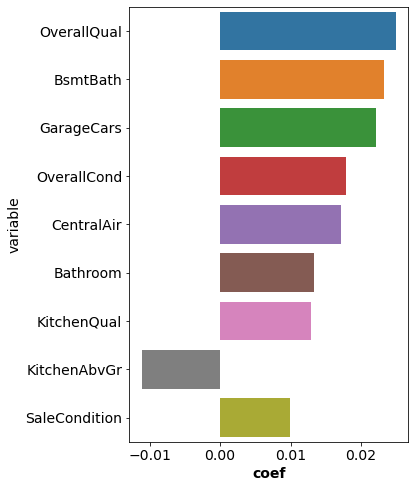

In [78]:
fig, ax = view_coeff(X, ols)
ax.set_xlabel('coef',fontsize=14, fontweight='bold')
#ax.set_title('OLS')
fig.savefig('output/ols_coef.png', transparent=False, bbox_inches='tight', dpi=300)

### **RidgeCV**

Alpha: 15.52225357427048
Score: 0.8993397213707942


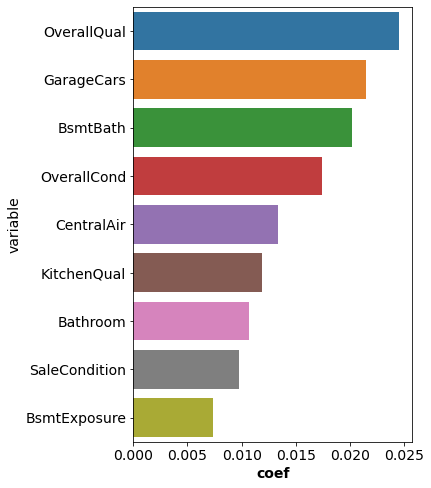

In [79]:
# create a range of alphas to calculate
ridge_alphas = np.logspace(-3, 3, 200)

X = X_train.copy()
y = np.log10(house_enc['SalePrice'])

optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=10)
optimal_ridge.fit(X, y)
ridge_score = optimal_ridge.score(X, y)
print('Alpha:', optimal_ridge.alpha_)
print('Score:', ridge_score)

fig, ax = view_coeff(X, optimal_ridge)
ax.set_xlabel('coef',fontsize=14, fontweight='bold')
#ax.set_title('RidgeCV')
fig.savefig('output/ridge_coef.png', transparent=False, bbox_inches='tight', dpi=300)

### **LassoCV**

Alpha: 2.523539170434766e-05
Score: 0.8984225491569495


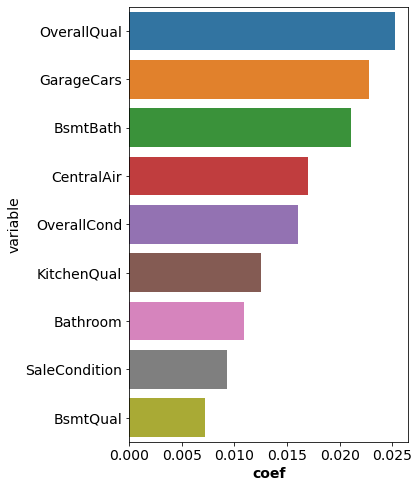

In [80]:
# create a range of alphas to calculate
lasso_alphas = np.logspace(-6, 3, 200)

X = X_train.copy()
y = np.log10(house_enc['SalePrice'])

optimal_lasso = LassoCV(alphas=lasso_alphas, normalize=True, cv=10)
optimal_lasso.fit(X, y)
lasso_score = optimal_lasso.score(X, y)
print('Alpha:', optimal_lasso.alpha_)
print('Score:', lasso_score)

fig, ax = view_coeff(X, optimal_lasso)
ax.set_xlabel('coef',fontsize=14, fontweight='bold')
#ax.set_title('LassoCV')
fig.savefig('output/lasso_coef.png', transparent=False, bbox_inches='tight', dpi=300)

### **Prediction**
- **$R^2$ score based on the whole training dataset**

In [49]:
Score = pd.DataFrame([ols_score, ridge_score, lasso_score],columns=[r'$R^2 score$'],index=['OLS','Ridge','Lasso'])
Score

,$R^2 score$
OLS,0.899120
Ridge,0.899340
Lasso,0.898423


### Section 3.3 Cross validation <a class="anchor" id="section_3_c"></a>


- **$R^2$ score by cross validation**

In [50]:
from sklearn.model_selection import cross_validate, cross_val_predict

X_ols = house_enc[predictors]
cross_score_ols = cross_validate(ols, X_ols, y,
                       scoring=['r2', 'neg_mean_absolute_error'],
                       n_jobs=-1, verbose=0)

cross_score_ridge = cross_validate(optimal_ridge, X, y,
                       scoring=['r2', 'neg_mean_absolute_error'],
                       n_jobs=-1, verbose=0)


cross_score_lasso = cross_validate(optimal_lasso, X, y,
                       scoring=['r2', 'neg_mean_absolute_error'],
                       n_jobs=-1, verbose=0)



In [54]:
val_score_ols=(r'${:.4f} \pm {:.3f}$').format(np.mean(cross_score_ols['test_r2']), np.std(cross_score_ols['test_r2']))
val_score_ridge=(r'${:.4f} \pm {:.3f}$').format(np.mean(cross_score_ridge['test_r2']), np.std(cross_score_ridge['test_r2']))
val_score_lasso=(r'${:.4f} \pm {:.3f}$').format(np.mean(cross_score_lasso['test_r2']), np.std(cross_score_lasso['test_r2']))
cross_score_ols

{'fit_time': array([0.01248097, 0.00861096, 0.0174787 , 0.01111078, 0.00799942]),
 'score_time': array([0.00299954, 0.00401855, 0.00300026, 0.00199461, 0.00199986]),
 'test_r2': array([0.92066521, 0.885408  , 0.90580019, 0.9022227 , 0.80697094]),
 'test_neg_mean_absolute_error': array([-0.03584328, -0.03958586, -0.03933053, -0.03845581, -0.03992337])}

- **summarise $R^2$ score in data frame**

In [55]:
Score = pd.DataFrame([[ols_score, val_score_ols],[ridge_score, val_score_ridge],[lasso_score,val_score_lasso]],columns=[r'$R^2 score$',r'$R^2$ validate'],index=['OLS','Ridge','Lasso'])
Score

,$R^2 score$,$R^2$ validate
OLS,0.899120,$0.8842 \pm 0.040$
Ridge,0.899340,$0.8784 \pm 0.050$
Lasso,0.898423,$0.8777 \pm 0.046$


- **graph the comparison of predicted SalePrice to true SalePrice**

In [56]:
score = cross_score_ols
score_str=(r'$R^2={:.3f} \pm {:.3f}$' + '\n' + r'$MAE={:.3f} \pm {:.3f}$').format(np.mean(score['test_r2']),
            np.std(score['test_r2']),
            -np.mean(score['test_neg_mean_absolute_error']),
            np.std(score['test_neg_mean_absolute_error']))


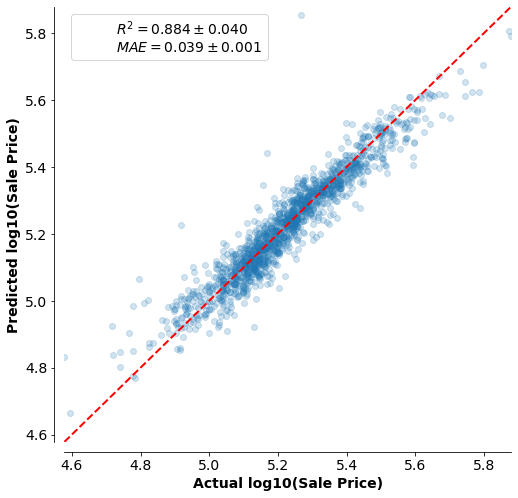

In [57]:
#y_pred = optimal_ridge.predict(X)
y_pred = cross_val_predict(ols, X, y, n_jobs=-1, verbose=0)

y_org = np.power(10.0, y)
y_pred_org = np.power(10.0, y_pred)

fig, ax = plt.subplots(figsize=[8,8])
ax.plot([y.min(), y.max()], [y.min(), y.max()], '--r', linewidth=2)
ax.scatter(y, y_pred, alpha=0.2)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))
ax.set_xlim([y.min(), y.max()])
ax.set_ylim([y.min(), y.max()])
ax.set_xlabel('Actual log10(Sale Price)',fontsize=14,fontweight='bold')
ax.set_ylabel('Predicted log10(Sale Price)',fontsize=14,fontweight='bold')
extra = plt.Rectangle((0, 0), 0, 0, fc="w", fill=False,
                      edgecolor='none', linewidth=0)
ax.legend([extra], [score_str], loc='upper left', prop={'size': 14})

plt.show()
fig.savefig('output/ols_predicted.png', transparent=False, bbox_inches='tight', dpi=300)

### **Prediction**

In [58]:
X = house_enc[predictors]
y = np.log10(house_enc['SalePrice'])

idx = 200

y_idx_pred = ols.predict([X.iloc[idx,:]])
y_idx = y[idx]
print(np.power(10,y_idx), np.power(10,y_idx_pred[0]))


140000.00000000006 153650.32297823625


In [59]:
X = X_train
y = np.log10(house_enc['SalePrice'])

idx = 200

y_idx_pred = optimal_ridge.predict([X.iloc[idx,:]])
y_idx = y[idx]
print(np.power(10,y_idx), np.power(10,y_idx_pred[0]))

140000.00000000006 154493.89719205064


## Section 4.  House price prediction <a class="anchor" id="section4"></a> 
### Section 4.1 Categorical features - one-hot encoding <a class="anchor" id="section_4_1"></a>


In [60]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

house['BsmtQual'].fillna(value='NA', inplace=True)
house['BsmtCond'].fillna(value='NA', inplace=True)
house['FireplaceQu'].fillna(value='NA', inplace=True)
house['GarageQual'].fillna(value='NA', inplace=True)
house['MasVnrType'].fillna(value='NA', inplace=True)
house['BsmtExposure'].fillna(value='NA', inplace=True)
house['BsmtFinType1'].fillna(value='NA', inplace=True)
house['GarageType'].fillna(value='NA', inplace=True)
house['GarageFinish'].fillna(value='NA', inplace=True)

cat_cols = ['ExterQual',
            'ExterCond',
            'BsmtQual',
            'BsmtCond',
            'HeatingQC',
            'KitchenQual',
            'FireplaceQu',
            'GarageQual',
            'MSZoning',
            'BldgType',
            'HouseStyle',
            'MasVnrType',
            'Foundation',
            'BsmtExposure',
            'BsmtFinType1',
            'GarageType',
            'GarageFinish',
            'CentralAir',
            'SaleCondition',
            'Neighborhood']

linear_model_preprocessor = ColumnTransformer(
    [("onehot_categorical", OneHotEncoder(), cat_cols),],
    remainder="passthrough",
)

In [62]:
cols = house.columns[house.dtypes != 'O']
linear_features = list(cols.difference(['SalePrice',
                                        'SalePrice_per_sqft',
                                        'LotFrontage',
                                        'GarageYrBlt',
                                        'MasVnrArea']))

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

lin_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ])

categorical_features = ['ExterQual','ExterCond',
                        'BsmtQual','BsmtCond',
                        'HeatingQC','KitchenQual',
                        'FireplaceQu','GarageQual',
                        'MSZoning','BldgType',
                        'HouseStyle','MasVnrType',
                        'Foundation','BsmtExposure',
                        'BsmtFinType1','GarageType',
                        'GarageFinish','CentralAir',
                        'SaleCondition','Neighborhood']

categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num_lin', lin_transformer, linear_features),
        ('cat', categorical_transformer, categorical_features),
        ],
)

numerical_features = linear_features
features = numerical_features + categorical_features
#display(features)

In [63]:
X = house[features]
print(X.shape)

y = np.log10(house['SalePrice'])


(1448, 51)


In [64]:
from sklearn.dummy import DummyRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

dummy = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", DummyRegressor(strategy='mean')),
]).fit(X, y)

y_pred = dummy.predict(X)

print("Dummy score: %.4f" %dummy.score(X,y))


Dummy score: 0.0000


### Section 4.2 Linear regression models <a class="anchor" id="section_4_2"></a>


In [65]:

linreg= Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", LinearRegression()),
]).fit(X, y)

y_pred = linreg.predict(X)

print("OLS score: %.4f" %linreg.score(X,y))
print("MSE: %.4f" %mean_squared_error(y, y_pred))
print("MAE: %.4f" %mean_absolute_error(y, y_pred))



OLS score: 0.9110
MSE: 0.0026
MAE: 0.0346


In [66]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

linreg= Pipeline([
    ("preprocessor", preprocessor),
#    ("regressor", LinearRegression()),
    ("regressor", RidgeCV()),
]).fit(X_train, y_train)

y_pred = linreg.predict(X_test)

print("OLS score: %.4f" %linreg.score(X_train,y_train))
print("OLS score: %.4f" %linreg.score(X_test,y_test))


OLS score: 0.9114
OLS score: 0.8888


In [100]:
linreg.named_steps

{'preprocessor': ColumnTransformer(transformers=[('num_lin',
                                  Pipeline(steps=[('imputer',
                                                   SimpleImputer(strategy='median'))]),
                                  ['1stFlrSF', '2ndFlrSF', '3SsnPorch',
                                   'AgeBuilt', 'AgeRemod', 'Bathroom',
                                   'BedroomAbvGr', 'BsmtBath', 'BsmtFinSF1',
                                   'BsmtFinSF2', 'BsmtUnfSF', 'EnclosedPorch',
                                   'Fireplaces', 'GarageArea', 'GarageCars',
                                   'GrLivArea', 'KitchenAbvGr', 'LotArea',
                                   'LowQualFinSF', 'MSSu...
                                   'TotRmsAbvGrd', 'TotalBsmtSF', 'WoodDeckSF', ...]),
                                 ('cat', OneHotEncoder(handle_unknown='ignore'),
                                  ['ExterQual', 'ExterCond', 'BsmtQual',
                                   'B

In [101]:
linreg.named_steps['regressor']

LinearRegression()

In [103]:
linreg.named_steps['preprocessor'].named_transformers_

{'num_lin': Pipeline(steps=[('imputer', SimpleImputer(strategy='median'))]),
 'cat': OneHotEncoder(handle_unknown='ignore')}

In [104]:
categorical_names = (linreg.named_steps['preprocessor']
                      .named_transformers_['cat']
                      .get_feature_names(input_features=cat_cols))

feature_names = np.concatenate([categorical_names, numerical_names])

coefs = pd.DataFrame(
    linreg.named_steps['regressor'].coef_,
    columns=['Coefficients'], index=feature_names
)

coefs['abs_coef']=np.abs(coefs['Coefficients'])
coefs_sorted = coefs.sort_values(by= 'abs_coef',ascending=True)
coefs_sorted

,Coefficients,abs_coef
HeatingQC_Fa,-2.233428e-07,2.233428e-07
BsmtCond_Po,5.884649e-07,5.884649e-07
BsmtQual_TA,-1.475264e-05,1.475264e-05
HeatingQC_Po,3.397838e-05,3.397838e-05
FireplaceQu_Fa,4.863223e-05,4.863223e-05
...,...,...
FireplaceQu_Po,-8.911094e+03,8.911094e+03
ExterCond_TA,3.085179e+06,3.085179e+06
FireplaceQu_Ex,-3.085179e+06,3.085179e+06
BsmtQual_Ex,3.085179e+06,3.085179e+06


### Section 4.3 Cross validation <a class="anchor" id="section_4_3"></a>


In [121]:
linreg= Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", LinearRegression()),
])

cross_score_linreg = cross_validate(linreg, X, y,
                                    scoring=['r2', 'neg_mean_absolute_error'],
                                    n_jobs=-1, verbose=0)
cross_score_linreg

{'fit_time': array([0.03811693, 0.03723454, 0.04218292, 0.03438592, 0.03237629]),
 'score_time': array([0.01306009, 0.01116538, 0.0096736 , 0.01299858, 0.01299858]),
 'test_r2': array([-1.85315237e+07, -1.96175403e+09,  8.90240383e-01, -3.44060420e+08,
         7.96934991e-01]),
 'test_neg_mean_absolute_error': array([-4.13605944e+01, -7.92098520e+02, -4.10211809e-02, -1.77897030e+02,
        -3.97082393e-02])}

**As suggested by the $R^2$ score of the test dataset, applying one-hot encoding to categorical features in linear regressor model results in overfitting. Therefore, regularization is necessary such as Ridge or Lasso regressors.**

In [68]:
rigreg= Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", RidgeCV(alphas=ridge_alphas)),
])

cross_score_rigreg = cross_validate(rigreg, X, y,
                                    scoring=['r2', 'neg_mean_absolute_error'],
                                    n_jobs=-1, verbose=0)
cross_score_rigreg

{'fit_time': array([0.39725494, 0.40585256, 0.4042244 , 0.40089893, 0.39079475]),
 'score_time': array([0.01160431, 0.01518416, 0.01148844, 0.0072484 , 0.00957203]),
 'test_r2': array([0.92252966, 0.87929328, 0.89950457, 0.90224086, 0.787958  ]),
 'test_neg_mean_absolute_error': array([-0.03474593, -0.03970346, -0.03892318, -0.03782469, -0.0383978 ])}

In [69]:
lasreg= Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", LassoCV(alphas=lasso_alphas)),
])

cross_score_lasreg = cross_validate(lasreg, X, y,
                                    scoring=['r2', 'neg_mean_absolute_error'],
                                    n_jobs=-1, verbose=0)
cross_score_lasreg

{'fit_time': array([2.54545856, 2.77935481, 3.26021051, 2.99914837, 3.51561332]),
 'score_time': array([0.01159382, 0.00852346, 0.00746775, 0.00797987, 0.00844407]),
 'test_r2': array([0.92173344, 0.87994956, 0.90058085, 0.90088358, 0.77795001]),
 'test_neg_mean_absolute_error': array([-0.03512599, -0.03961265, -0.03885404, -0.03804898, -0.03816486])}

In [70]:
val_score_linreg ='0.0'
val_score_rigreg = (r'${:.3f} \pm {:.3f}$').format(np.mean(cross_score_rigreg['test_r2']), np.std(cross_score_rigreg['test_r2']))
val_score_lasreg = (r'${:.3f} \pm {:.3f}$').format(np.mean(cross_score_lasreg['test_r2']), np.std(cross_score_lasreg['test_r2']))


In [71]:
Score = pd.DataFrame([[ols_score, val_score_ols,val_score_linreg],
                      [ridge_score, val_score_ridge,val_score_rigreg],
                      [lasso_score,val_score_lasso,val_score_lasreg]],
                     columns=[r'$R^2 score$',r'$R^2$ validate (ordinal)',r'$R^2$ validate (one-hot)'],
                     index=['OLS','Ridge','Lasso'])
Score

,$R^2 score$,$R^2$ validate (ordinal),$R^2$ validate (one-hot)
OLS,0.899120,$0.8842 \pm 0.040$,0.0
Ridge,0.899340,$0.8784 \pm 0.050$,$0.878 \pm 0.047$
Lasso,0.898423,$0.8777 \pm 0.046$,$0.876 \pm 0.051$


## Section 5.  Summary <a class="anchor" id="section5"></a> 


- The median house price in Ames neighborhood and the proximity to amenities are visualised on geometrical map. The mapping suggests that the median house price tends to decrease with distance to parklands but increase with distance to Uni or airport.
- For the prediction of Ames house price, in total only 12 outliers (10 commercial and two in neighborhood "Blueste") is removed. 
- Ordinal encoding and one hot encoding are used for categorical features. Both achieved identical cross-validated R2 score up to 0.88. However, applying one hot encoding to linear regressor model results in low R2 score of test dataset. That is regularization is required to prevent overfitting.